In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
pd.pandas.set_option("display.max_columns", None)
# Create Dataframe
df = pd.read_csv(r"Visadataset.csv")
# Print shape of dataset
print(df.shape)

(25480, 12)


In [2]:
features_with_na=[features for features in df.columns if df[features].isnull().sum()>=1]
for feature in features_with_na:
    print(feature,np.round(df[feature].isnull().mean()*100,5), '% missing values')

In [3]:
features_with_na

[]

-There are no null values in the dataset

-Handling Duplicates

In [4]:
df.duplicated().sum()

0

In [6]:
df.drop(columns = 'case_id' , inplace=True, axis=1)

In [7]:
# importing date class from datetime module
from datetime import date
  
# creating the date object of today's date
todays_date = date.today()
current_year= todays_date.year

In [8]:
current_year

2024

In [9]:
df['company_age'] = current_year-df['yr_of_estab']

In [10]:
df.head()

,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status,company_age
0,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,Denied,17
1,Asia,Master's,Y,N,2412,2002,Northeast,83425.6500,Year,Y,Certified,22
2,Asia,Bachelor's,N,Y,44444,2008,West,122996.8600,Year,Y,Denied,16
3,Asia,Bachelor's,N,N,98,1897,West,83434.0300,Year,Y,Denied,127
4,Africa,Master's,Y,N,1082,2005,South,149907.3900,Year,Y,Certified,19


In [11]:
df.drop('yr_of_estab', inplace=True, axis=1)

In [12]:
X = df.drop('case_status', axis=1)
y = df['case_status']

In [15]:
y.head()

0       Denied
1    Certified
2       Denied
3       Denied
4    Certified
Name: case_status, dtype: object

In [16]:
y= np.where(y=='Denied', 1,0)

In [17]:
num_features = [feature for feature in df.columns if df[feature].dtype != 'O']
print('Num of Numerical Features :', len(num_features))

cat_features = [feature for feature in df.columns if df[feature].dtype == 'O']
print('Num of Categorical Features :', len(cat_features))

discrete_features=[feature for feature in num_features if len(df[feature].unique())<=25]
print('Num of Discrete Features :',len(discrete_features))

continuous_features=[feature for feature in num_features if feature not in discrete_features]
print('Num of Continuous Features :',len(continuous_features))

Num of Numerical Features : 3
Num of Categorical Features : 8
Num of Discrete Features : 0
Num of Continuous Features : 3


-Check Skewness

In [18]:
X[continuous_features].skew(axis=0, skipna=True)

no_of_employees    12.265260
prevailing_wage     0.755776
company_age         2.037301
dtype: float64

-Positiviely Skewed : company_age, no_of_employees.

In [20]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method='yeo-johnson')
transform_features = ['company_age', 'no_of_employees']
X_copy = pt.fit_transform(X[transform_features])
X_copy = pd.DataFrame(X_copy, columns=transform_features)

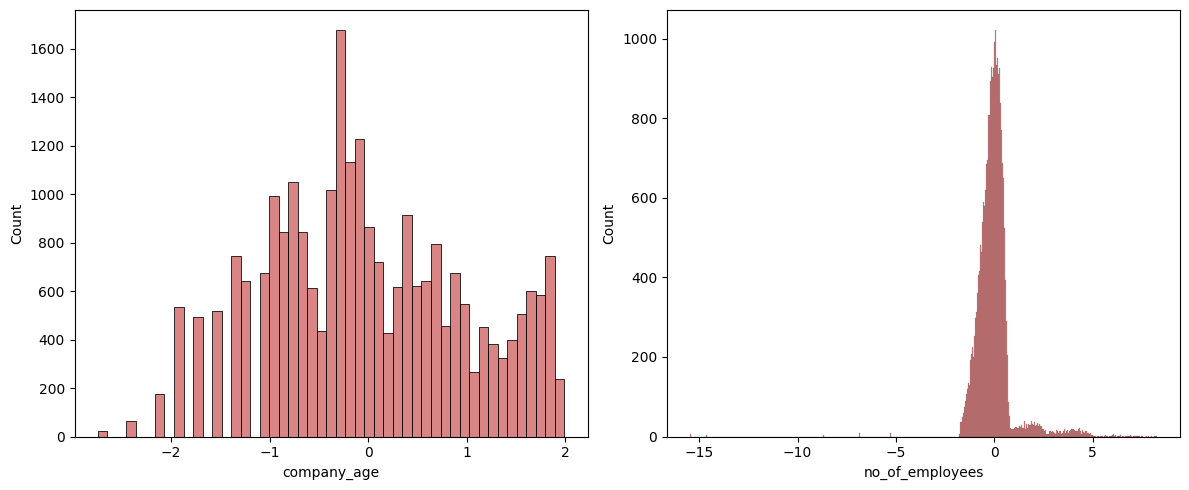

In [21]:
plt.figure(figsize=(12, 5))
for i, col in enumerate(transform_features):
    plt.subplot(1, 2, i+1)
    sns.histplot(x=X_copy[col], color='indianred')
    plt.xlabel(col)
    plt.tight_layout()
    

In [22]:
# Create Column Transformer with 3 types of transformers
or_columns = ['has_job_experience','requires_job_training','full_time_position','education_of_employee']
oh_columns = ['continent','unit_of_wage','region_of_employment']
transform_columns= ['no_of_employees','company_age']

from sklearn.preprocessing import OneHotEncoder, StandardScaler,OrdinalEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer 
from sklearn.pipeline import Pipeline

numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()
ordinal_encoder = OrdinalEncoder()

transform_pipe = Pipeline(steps=[
    ('transformer', PowerTransformer(method='yeo-johnson'))
])

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", oh_transformer, oh_columns),
        ("Ordinal_Encoder", ordinal_encoder, or_columns),
        ("Transformer", transform_pipe, transform_columns),
        ("StandardScaler", numeric_transformer, num_features)
    ]
)

In [23]:
X = preprocessor.fit_transform(X)

In [24]:
X

array([[ 0.        ,  1.        ,  0.        , ...,  0.38666657,
        -1.39853722, -0.65122993],
       [ 0.        ,  1.        ,  0.        , ..., -0.14228155,
         0.1698353 , -0.53321103],
       [ 0.        ,  1.        ,  0.        , ...,  1.69498375,
         0.91907852, -0.6748337 ],
       ...,
       [ 0.        ,  1.        ,  0.        , ..., -0.19871259,
         1.36027953,  1.63833662],
       [ 0.        ,  1.        ,  0.        , ..., -0.16387483,
         0.22150859,  2.18122353],
       [ 0.        ,  1.        ,  0.        , ..., -0.10805575,
        -0.06776315,  0.45814768]])

In [25]:
from imblearn.combine import SMOTETomek, SMOTEENN

# Resampling the minority class. The strategy can be changed as required.
smt = SMOTEENN(random_state=42,sampling_strategy='minority' )
# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(X, y)

In [35]:
from sklearn.model_selection import  train_test_split
# separate dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X_res,y_res,test_size=0.2,random_state=42)
X_train.shape, X_test.shape

((13638, 24), (3410, 24))

In [26]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report,ConfusionMatrixDisplay, \
                            precision_score, recall_score, f1_score, roc_auc_score,roc_curve 
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [27]:
def evaluate_clf(true, predicted):
    acc = accuracy_score(true, predicted) # Calculate Accuracy
    f1 = f1_score(true, predicted) # Calculate F1-score
    precision = precision_score(true, predicted) # Calculate Precision
    recall = recall_score(true, predicted)  # Calculate Recall
    roc_auc = roc_auc_score(true, predicted) #Calculate Roc
    return acc, f1 , precision, recall, roc_auc

In [28]:
models = {
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression(),
     "K-Neighbors Classifier": KNeighborsClassifier(),
    "XGBClassifier": XGBClassifier(), 
     "CatBoosting Classifier": CatBoostClassifier(verbose=False),
     "Support Vector Classifier": SVC(),
    "AdaBoost Classifier": AdaBoostClassifier()

}

In [33]:
# Create a function which can evaluate models and return a report 
def evaluate_models(X, y, models):
    '''
    This function takes in X and y and models dictionary as input
    It splits the data into Train Test split
    Iterates through the given model dictionary and evaluates the metrics
    Returns: Dataframe which contains report of all models metrics with cost
    '''
    # separate dataset into train and test
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
    
    models_list = []
    accuracy_list = []
    auc= []
    
    for i in range(len(list(models))):
        model = list(models.values())[i]
        model.fit(X_train, y_train) # Train model

        # Make predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Training set performance
        model_train_accuracy, model_train_f1,model_train_precision,\
        model_train_recall,model_train_rocauc_score=evaluate_clf(y_train ,y_train_pred)


        # Test set performance
        model_test_accuracy,model_test_f1,model_test_precision,\
        model_test_recall,model_test_rocauc_score=evaluate_clf(y_test, y_test_pred)

        print(list(models.keys())[i])
        models_list.append(list(models.keys())[i])

        print('Model performance for Training set')
        print("- Accuracy: {:.4f}".format(model_train_accuracy))
        print('- F1 score: {:.4f}'.format(model_train_f1)) 
        print('- Precision: {:.4f}'.format(model_train_precision))
        print('- Recall: {:.4f}'.format(model_train_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_train_rocauc_score))

        print('----------------------------------')

        print('Model performance for Test set')
        print('- Accuracy: {:.4f}'.format(model_test_accuracy))
        accuracy_list.append(model_test_accuracy)
        print('- F1 score: {:.4f}'.format(model_test_f1))
        print('- Precision: {:.4f}'.format(model_test_precision))
        print('- Recall: {:.4f}'.format(model_test_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_test_rocauc_score))
        auc.append(model_test_rocauc_score)
        print('='*35)
        print('\n')
        
    report=pd.DataFrame(list(zip(models_list, accuracy_list)), columns=['Model Name', 'Accuracy']).sort_values(by=['Accuracy'], ascending=False)
        
    return report
    

In [36]:
base_model_report =evaluate_models(X=X_res, y=y_res, models=models)

Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9563
- F1 score: 0.9597
- Precision: 0.9595
- Recall: 0.9600
- Roc Auc Score: 0.9560


Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9270
- F1 score: 0.9330
- Precision: 0.9283
- Recall: 0.9378
- Roc Auc Score: 0.9260


Gradient Boosting
Model performance for Training set
- Accuracy: 0.8822
- F1 score: 0.8903
- Precision: 0.8945
- Recall: 0.8862
- Roc Auc Score: 0.8819
----------------------------------
Model performance for Test set
- Accuracy: 0.8956
- F1 score: 0.9031
- Precision: 0.9095
- Recall: 0.8967
- Roc Auc Score: 0.8955


Logistic Regression
Model performance for Training 

In [37]:
base_model_report

,Model Name,Accuracy
0,Random Forest,0.956305
4,K-Neighbors Classifier,0.940176
5,XGBClassifier,0.935191
6,CatBoosting Classifier,0.929619
1,Decision Tree,0.926979
2,Gradient Boosting,0.895601
7,Support Vector Classifier,0.870088
8,AdaBoost Classifier,0.868328
3,Logistic Regression,0.744868


Here we can use Random Forest for Hyper Parameter Tuning

Define the parameter distribution for Random forest

In [39]:
xgboost_params = {
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,6,2)
}

rf_params = {
    "max_depth": [10, 12, None, 15, 20],
    "max_features": ['sqrt', 'log2', None],
    "n_estimators": [10, 50, 100, 200]
}

knn_params = {
    "algorithm": ['auto', 'ball_tree', 'kd_tree','brute'],
    "weights": ['uniform', 'distance'],
    "n_neighbors": [3, 4, 5, 7, 9],
}

In [40]:
randomcv_models = [
    ('XGBoost', XGBClassifier(), xgboost_params),
    ("RF", RandomForestClassifier(), rf_params),
    ("KNN", KNeighborsClassifier(), knn_params)
]

In [41]:
from sklearn.model_selection import RandomizedSearchCV

model_param = {}
for name, model, params in randomcv_models:
    random = RandomizedSearchCV(estimator=model,
                                   param_distributions=params,
                                   n_iter=100,
                                   cv=3,
                                   verbose=2, 
                                   n_jobs=-1)
    random.fit(X_res, y_res)
    model_param[name] = random.best_params_

for model_name in model_param:
    print(f"---------------- Best Params for {model_name} -------------------")
    print(model_param[model_name])

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Fitting 3 folds for each of 60 candidates, totalling 180 fits
Fitting 3 folds for each of 40 candidates, totalling 120 fits
---------------- Best Params for XGBoost -------------------
{'min_child_weight': 1, 'max_depth': 9}
---------------- Best Params for RF -------------------
{'n_estimators': 200, 'max_features': 'log2', 'max_depth': None}
---------------- Best Params for KNN -------------------
{'weights': 'distance', 'n_neighbors': 4, 'algorithm': 'auto'}


In [42]:
model_param

{'XGBoost': {'min_child_weight': 1, 'max_depth': 9},
 'RF': {'n_estimators': 200, 'max_features': 'log2', 'max_depth': None},
 'KNN': {'weights': 'distance', 'n_neighbors': 4, 'algorithm': 'auto'}}

In [43]:
from sklearn.metrics import roc_auc_score,roc_curve
best_models = {
    "Random Forest Classifier": RandomForestClassifier(**model_param['RF']),
    "KNeighborsClassifier": KNeighborsClassifier(**model_param['KNN']),
    "XGBClassifier": XGBClassifier(**model_param['XGBoost'],n_jobs=-1),
}
tuned_report =evaluate_models(X=X_res, y=y_res, models=best_models)

Random Forest Classifier
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9560
- F1 score: 0.9596
- Precision: 0.9555
- Recall: 0.9638
- Roc Auc Score: 0.9553


KNeighborsClassifier
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9733
- F1 score: 0.9757
- Precision: 0.9651
- Recall: 0.9865
- Roc Auc Score: 0.9721


XGBClassifier
Model performance for Training set
- Accuracy: 0.9995
- F1 score: 0.9995
- Precision: 0.9993
- Recall: 0.9997
- Roc Auc Score: 0.9995
----------------------------------
Model performance for Test set
- Accuracy: 0.9455
- F1 score: 0.9498
- Precision: 0.9487
- Recall: 0.9508
- Roc Auc Score: 0.9450




In [44]:
tuned_report

,Model Name,Accuracy
1,KNeighborsClassifier,0.973314
0,Random Forest Classifier,0.956012
2,XGBClassifier,0.945455


In [45]:
best_model = KNeighborsClassifier(**model_param['KNN'])
best_model = best_model.fit(X_train,y_train)
y_pred = best_model.predict(X_test)
score = accuracy_score(y_test,y_pred)
cr = classification_report(y_test,y_pred)

print("FINAL MODEL 'KNN'")
print ("Accuracy Score value: {:.4f}".format(score))
print (cr)

FINAL MODEL 'KNN'
Accuracy Score value: 0.9733
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1561
           1       0.97      0.99      0.98      1849

    accuracy                           0.97      3410
   macro avg       0.97      0.97      0.97      3410
weighted avg       0.97      0.97      0.97      3410



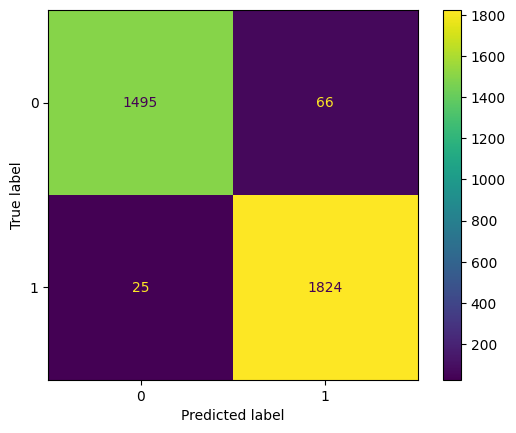

In [46]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)

# Best Model is K-Nearest Neighbor(KNN) with Accuracy 96.66%